<a href="https://colab.research.google.com/github/haydenclose/Cloud_based_Oil_Detection/blob/main/UserInterface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cloud Based Analysis of Oil Spills from Wrecks
This is a workflow on how to use Google Earth Engine (GEE) with Google Colab to identify and detect oil from shipwreck

Created By Hayden Close (Cefas)
hayden.close@cefas.gov.uk

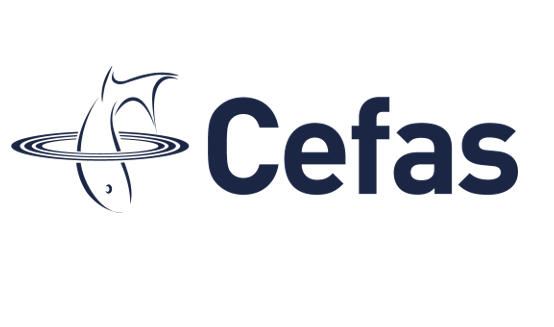

#1 Installation and set-up of workspace

## 1.1 Connect to google drive
First of all connect your google drive account with colab so you can store inputs such as wreck locations and even scripts with functions in.

Note: the wreck database is located on the sharepoint for Cefas Staff.

In [1]:
import google.colab.drive
google.colab.drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##1.2 Install and import required libraries
Google Colab has lots of packages aready installed but some need to be installed via `!pip install name` and
`import name`

use `> /dev/null 2>&1; ` to supress outputs as lengthy and clog up the screen.



In [8]:
!pip install geemap > /dev/null 2>&1;                                                               # Need to install geeMap for easy iteractive plotting
#geemap.update_package()
!pip install geopandas > /dev/null 2>&1;                                                            # Install geopandas
!pip install plotly > /dev/null 2>&1;                                                               # Install Ploty for interactive graphs
import ee                                                                                           # To access the earth engine catalogue
import geemap                                                                                       # Imports the geeMap package into environment
import geopandas                                                                                    # Makes working with geospatial data in python easier
import pandas as pd                                                                                 # Useful package to read/export csv's etc...
import ipyleaflet                                                                                   # Needed for interactive plotting
import ipywidgets as widgets                                                                        # Way to have widgets onto geemaps
import math                                                                                         # Used in the gammafilter function
import plotly.express as px                                                                         # Used to plot the spills over time or the values from a line
import os
import requests
from typing import Union, List
from PIL import Image
import glob
print('Libraries installed')


##1.3 Download Wreck Tools python functions file

Download the wreck tools python file with all the functions to run the tools.
The below codes downloads the file with from GitHib with the latest updates. See the script for documentation of the various functions.


In [3]:
os.chdir('/content')
!wget -N https://raw.githubusercontent.com/haydenclose/Cloud_based_Oil_Detection/main/Cloud_Based_Oil_Tools.ipynb
%run '/content/Cloud_Based_Oil_Tools.ipynb'

--2023-11-09 09:27:17--  https://raw.githubusercontent.com/haydenclose/Cloud_based_Oil_Detection/main/Cloud_Based_Oil_Tools.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90395 (88K) [text/plain]
Saving to: ‘Cloud_Based_Oil_Tools.ipynb’

Cloud_Based_Oil_Too 100%[===================>]  88.28K  --.-KB/s    in 0.007s  

Last-modified header missing -- time-stamps turned off.
2023-11-09 09:27:17 (11.5 MB/s) - ‘Cloud_Based_Oil_Tools.ipynb’ saved [90395/90395]



##1.4 Autenticate Earth Engine servers
To access the imagery catalogues you are required to autenticate yourself via your google account. To do this run the `ee.Authenticate` function to authenticate your access to Earth Engine servers and `ee.Initialize` to initialize it. Upon running the following cell you'll need to click the link and follow the instruction to grant Earth Engine access to your Google account. Authorisation last a week but sometimes need doing again if refreshed.

In [4]:
# Trigger the authentication flow.. Only need to do once a week
ee.Authenticate()

# Initialize the library
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=gbdHvuO-Nwv47lOaWGxehpra9_XiPYnsSWg4hDtiXWg&tc=lVOalBhuLOs9keOCd7cTzUZUuLRP_oJigxGr6Y7q5u4&cc=VMWuWND0s_Kehu7M24SoTkLX6SddjLl76zUQUYO9UOA

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfJohXnRz7Bk5Wk3rFuCi4XpqIpKNH-5WwEjF7fXD5eOw7RBhwPgYlNwW0M

Successfully saved authorization token.


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_doiqkQG3NJ1t8IS?source=API


# 2 Set up mapping parameters
Run the below `SetUp()` to generate the options to tailor the mapping.

1.   Drop down of pre-dertermined wrecks from an CSV that should be uploaded to your google drive. Dont place within a folder.
2.   Select the start date, either type it or click the calendar icon to select the date.
3.   Select the end date, either type it or click the calendar icon to select the date.
4.   Click the satellites that you wish to use.
      *   SENTINEL-1 - Only uses this satellite in the tool that uses Synthetic-aperture radar (SAR) that is not affected by cloud cover.
      *   SENTINEL-2 - Only uses visibile light with multispectral sensors but cannot see through clouds.
      *   BOTH - Uses both satellites in the tool.

5.   Select the orbit pass of the SENTINEL-1 satallite whether you want to use ascending, descending or both.

6.   Select the maximum cloud percentage. Unless lots of cloud, 100% recommend as the area of interest may not actually be covered.
7.   Select the pixel dilation factor, expands the selected pixels from the threshold by this number
8.   Removes objects that have a total number of pixels smaller than this number.















In [5]:
SetUp()

Dropdown(description='Wreck:', index=3, options=('SS DERBENT', 'HMS PRINCE OF WALES old location', 'HMS PRINCE…

DatePicker(value=None, description='Start Date')

DatePicker(value=None, description='End Date')

RadioButtons(description='Satellites:', index=2, options=('SENTINEL-1', 'SENTINEL-2', 'BOTH'), value='BOTH')

RadioButtons(description='Sentinel-1 Orbit Pass:', index=2, options=('ASCENDING', 'DESCENDING', 'BOTH'), value…

IntSlider(value=100, description='Max cloud%', layout=Layout(width='400px'))

IntSlider(value=3, description='Dilation factor', layout=Layout(width='400px'), max=30)

IntSlider(value=250, description='Pixel Filter', layout=Layout(width='400px'), max=1000)

# 3 Create Timelapses
You can change the speed of the Timelapse using the Frames Per Second (FPS) slider. Additionally you can adjust the quality of the images downloaded although you may get an error for values much past `2700`.



*   Depending on how many images there are in the time period, it can take a few minutes to half an hour to start downloading the images, so please dont keep pressing the `Run TimeLapse` button.
*    The images are downloaded using parellel processing so may not appear in order.
*   Sometime colab may stop responding, check your google drive to see if the process is still runing before restarting. Multiple years will take many hours to download.
*   If you restart colab, the tool will automatically skip any images that have been downloaded. **ENSURE** the date range is the same.
*    Once it has finished it may provide a **warning** that you can ignore and will print `TimeLapse created` once finished.
*   Downloaded images are automatically deleted to save space and declutter.

See below for how to download and view the timelapses.



In [ ]:
CreateTimeLapse()

FloatSlider(value=0.25, description='FPS', layout=Layout(width='400px'), max=1.0, min=0.1, step=0.05)

IntSlider(value=2700, description='Resolution', layout=Layout(width='400px'), max=3000, min=500, step=50)

Button(description='Run TimeLapse', style=ButtonStyle())

# 3.1 Downloading and Viewing Timelapses

You can download the videos by going to the files on the right hand side, hover over the timelapse of interest and click the three dots to the right of the name. Click download from the popup box and your web browser should automatically start downloading it. If you cannot play the video on your computer you may need to download the latest 'mp4' codecs for playing the video software on your laptop, alternatively you can download a free open source videoplayer called VLC, this has many of these built in and is widely used as an alternative. This can be downloaded from the [VLC website](https://www.videolan.org/vlc/). You may need admin permissions to install.

Alternatively, you can view your timelapses in your google drive online, but can be slow and the image quality is reduced.

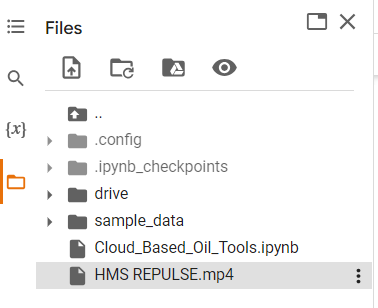

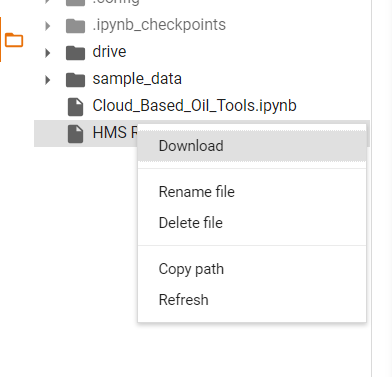

#4 Run the Mapping tool
The code below can take a few seconds to initiate.

 **1.** If no oil detected just press next image button (bottom right).
 >>**A.** If on the image you see potential oil use the polygon or rectangle tool to draw around the slick (toolbar on the left).

**2.**   Next press the detect potential oil button


>> **A.** If the oil is not delineated, try changing the pixel threshold values (bottom left slider), if unsure of values use the threshold detector tool below

>> **B.** If still not showing try reducing the pixel filter value in the slider in the set-up above where you select the wreck and dates.


**3.**   Once happy with the delineation, press next image. This will move on to the next sequential image in the image collection. This will save the polygon/append to existing ones. Additionally it will add the data to the table along with the metadata.

**4.** A random colour will be applied to the delineated slick. The tool will also only show the latest three delineated oil slicks

**5.** If you want to go back to a previous image, press the 'previous image' button (bottom left).
>>**A.** If you go back you will need re delineate the oil slicks as the data will be overwritten, assumes no oil.

***NOTE:*** Sometime the tool can be very slow, this is generally related to high usage on the google servers.











In [9]:
OilMapping()

Map(center=[3.620619000000001, 104.34518100000001], controls=(WidgetControl(options=['position', 'transparent_…

##4.1 Displaying the data
Run the below code to show the data. Here you can also add a comment for the previous image. i.e. **Commit comment** once you have gone to the next or previous image

*Note for the comment to show in the table you need to rerun the code*

In [ ]:
Display_Data()

Textarea(value='', description='Comment:', placeholder='Add comment for image here')

Button(description='Commit comment', icon='check', style=ButtonStyle(), tooltip='Description')

Wreck_Name                                           Image_ID  \
0  HMS ROYAL OAK           2_20231002T114349_20231002T114348_T30VVL   
1  HMS ROYAL OAK  1_S1A_IW_GRDH_1SDV_20231003T063750_20231003T06...   
2  HMS ROYAL OAK  1_S1A_IW_GRDH_1SDV_20231003T175154_20231003T17...   
3  HMS ROYAL OAK           2_20231004T113321_20231004T113319_T30VVL   
4  HMS ROYAL OAK           2_20231007T114351_20231007T114347_T30VVL   
5  HMS ROYAL OAK  1_S1A_IW_GRDH_1SDV_20231008T180004_20231008T18...   

         Date   Oil_Area_m2  Low_Threshold  High_Threshold    Satellite  \
0  2023-10-02  1.342162e+06         2350.0          3000.0  Sentinel-2B   
1  2023-10-03  1.557804e+06           -5.0            -5.0  SENTINEL-1A   
2  2023-10-03  3.425188e+06          -25.0            -5.0  SENTINEL-1A   
3  2023-10-04  0.000000e+00         1000.0          1000.0  Sentinel-2A   
4  2023-10-07  0.000000e+00         2350.0          3000.0  Sentinel-2A   
5  2023-10-08  2.787481e+06           -5.0            -5.0  SENTINEL-1A   

  Comment  
0          
1          
2          
3          
4          
5

##4.2 Tool for optimising the Threshold
Draw a line on the map across the suspected oil spill then run the tool below get an interactive chart. For detailed instructions see below section `3.21`

##4.21 Instructions on how to optimise the thresholding

If you are having difficulties getting the correct value for the threshold you can use the below tool.
First clear all drawing on the map by using the bin icon in the widgets on the left hand side and press clear all. 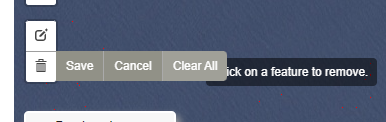

Afterwards draw a line across the expected oil leak like the image below using the line tool. Double click the last point to finish the line.

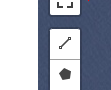

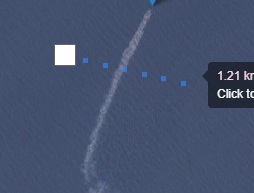

 Note the line can have multiple points and doesnt have to be straight. The graph produced is interactive and the threshold can then be determined.

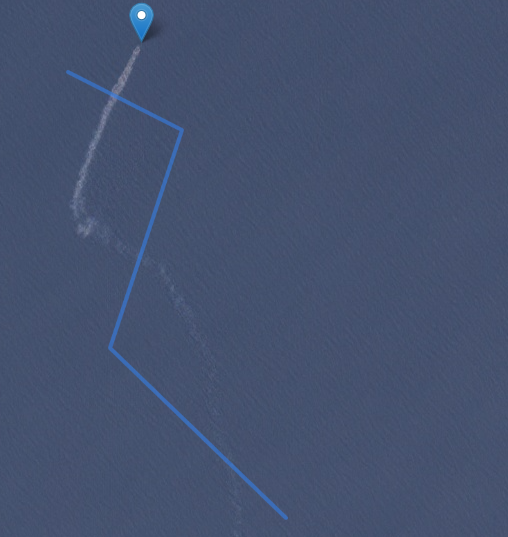



##4.22 Threshold tool
Before running, draw a small line across any potential oil features then run the tool as instructions above. The result is a plot with pixel values across this line where you can attempt to pick out a value.

In [ ]:
value_detector(img)

# 4 Download the Data as a CSV

In [ ]:
Datatable.to_csv(f'/content/drive/MyDrive/{WRKdropdown.value}/{WRKdropdown.value}_Oil_Spill_Data.csv')

## 5 Final Figure
Plots the all the polygons on an interactive map to explore all polygons delineated

In [ ]:
Plot_Polygons()

Map(center=[58.93077999999999, -2.98333], controls=(WidgetControl(options=['position', 'transparent_bg'], widg…

#6 Download polygons as shapefile
Downloads the polygons as a shapefile. **Note** it can take a little while to start the download. The progress is printed every 5 seconds and will change from READY to RUNNING to COMPLETED.

In [ ]:
download_shapefile()

Download READY waiting on google servers to start download
Download READY waiting on google servers to start download
Download RUNNING waiting on google servers to start download
Download RUNNING
Download RUNNING
Download COMPLETED
